In [1]:
#Required Packages for the problem
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import explained_variance_score
import seaborn as sn
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

## Abstract

A number of quality checks have been performed and corrections were done to clean the dataset. The checks include logical checks of High and Low prices for a given day, the price bounds (price >0) , signal bounds, NaN imputation, and outlier imputation. After cleaning the dataset, the efficacy of the signal is tested using regression analysis, and 'price forecast' was estimated from the signal by establishing a relationship between 'signal' and price forecast. This relationship is tested out-of-sample and different accuracy measures are presented, along with ideas to research it further and recommendations were given for next steps to be used by a portfolio manager

## Quality Checks

Quality CheckList:

1. High >= Open,Close,Low ; Low <= High,Close,Open

    High Price should always be greater than or equal to Open, Close, and Low;
    
    Low Price should always be less than or equal to Open, Close, and High;
       
    Solution: Replace the High price with the maximum of Open, Close, and Low when the issue is present. Replace the Low price
    as the minimum of Open, Close, and High prices
    
2. ETF Prices should always be >=0 (High, Low, Open, Close, Adj Close).
    For this particular dataset, this problem is taken care while treating outliers. so no additional solution was recommended.
    For other cases, there might be need to impute for negative prices as well. 
    
3. Signal values > 0. 
    Signal = 0 is less than (mean - 3*SD) which seems to be an outlier.The last few(6) entries of the dataset have 0 (Seems like
    signal is not updated for the last 6 entries)

4. Identifying null values, missing values in the price series. If there aren't any, look for outliers. In this particular dataset, there were no null or missing values. As this is a time-series dataset, in-case of any null or missing values, it is recommended to impute them with either a forward fill approach or a seven-day moving average. 

5. Outliers are identified based on z approach. The idea is to calculate returns of the price series first. The returns are assumed to follow a normal distribution. Because of this assumption, we can standardize the variables. Taking a rolling mean and rolling standard deviation of the variables for 50 days, we can calculate z for each variable. If z > 3 or z < -3, we can treat it as an outlier and replace it with a NaN value. This information is merged with price series and outliers are identified. The NaN values are then treated using a time-series specific 'forward fill' approach. 

6. Checking if the values are availabe for all the calendar trading days, or if there are any values missing, impute missing values with 'forward-fill' or seven-day moving average approach.

In [2]:
#Helper Functions
def QualityCheck1(df):
    #Replacing the High price with the maximum of Open, Close, and Low when the issue is present. 
    #Replacing the Low price as the minimum of Open, Close, and High prices
    df['High'] = np.where((df['High'] < df['Close']) | (df['High'] < df['Open']) | (df['High'] < df['Low']),df[['Open','Close','Low']].max(axis=1),df['High'])
    df['Low'] = np.where((df['Low'] > df['Close']) | (df['Low'] > df['Open']) | (df['Low'] > df['High']),df[['Open','Close','High']].min(axis=1),df['Low'])

    return df

def QualityCheck2(df):
    #Filtering out data with no signal
    len_before = len(df)
    df = df[df['Signal'] > 0]
    len_after = len(df)
    return df,len_before,len_after

def QualityCheck3(df,threshold,rolling_values):
    #Outlier detection using rolling z spread approach and replacing them with NAN values.
    #NAN values are treated using time-series imputation technique (ffill)
    ret_df = df.pct_change()[1:]
    z_score = (ret_df[rolling_values-1:] - ret_df.rolling(rolling_values).mean()[rolling_values-1:])/ret_df.rolling(rolling_values).std()[rolling_values-1:]
    for col in z_score.columns:
        z_score.loc[z_score[col] > threshold, col] = np.nan
        z_score.loc[z_score[col] <-threshold, col] = np.nan
        z_score.loc[z_score[col].notnull(),col] = 1
    new_df = z_score*df[rolling_values:]
    new_df = new_df.fillna(method='ffill')        
    return new_df

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Rule 2, 6  omitted


<AxesSubplot:title={'center':'Data after Data Cleaning'}, xlabel='Date'>

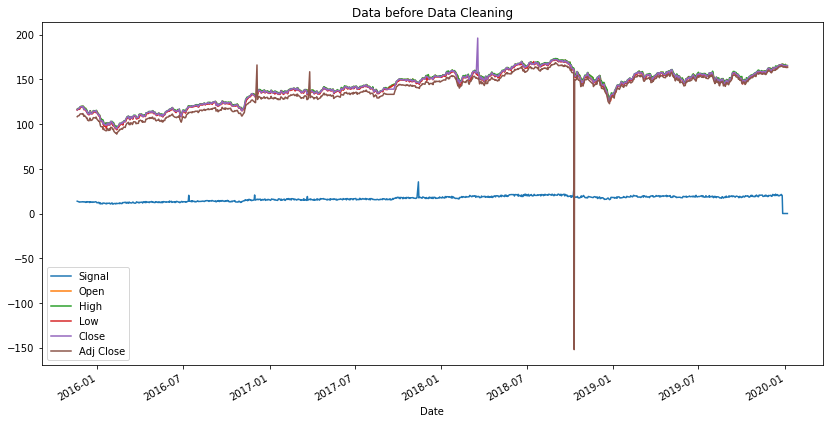

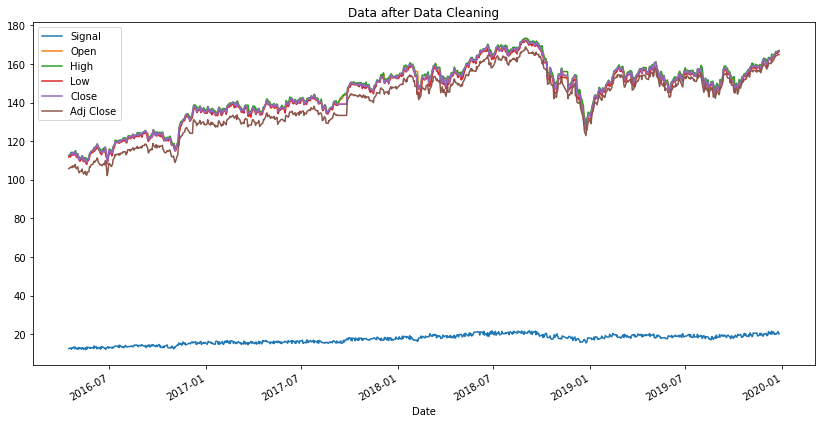

In [3]:
df = pd.read_excel('SampleData.xlsx',index_col='Date')
#Plotting the data before cleaning 
df.plot(figsize = (14,7),title = 'Data before Data Cleaning')
df = QualityCheck1(df)
df,l_before,l_after = QualityCheck2(df)
print('Rule 2,', l_before-l_after,' omitted')
df = QualityCheck3(df,3,100)
#Plotting the data after data cleaning
df.plot(figsize = (14,7),title = 'Data after Data Cleaning')

The data is cleaned, and the spikes and outliers are removed, along with the nan-values.

In [4]:
#A peek into the dataset given
df.describe()

,Signal,Open,High,Low,Close,Adj Close
count,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000
mean,17.330498,145.412167,146.250536,144.416159,145.352618,140.252006
std,2.385599,15.294577,15.310210,15.188205,15.236181,16.168698
min,11.995218,108.809998,109.769997,107.989998,108.690002,102.151489
25%,15.612868,136.387497,137.237499,135.532494,136.277500,129.862358
50%,17.768941,149.095002,150.004998,148.070000,149.250000,144.399964
75%,19.143664,156.062504,157.009998,154.850006,156.102505,152.326847
max,21.712125,172.789993,173.389999,171.949997,172.500000,168.842270


## Analyzing the signal’s effectiveness in forecasting ETF price

Assumptions:

Since no additional information about the signal is given, different possibilities can arise. 
    
    1.The signal is for the current day's price forecast 
    
    2.The signal is for the next day's price forecast
    
    3.The signal is for the next week's price forecast

Preliminary Analysis:

To establish whether the signal and the price series are moving together or not,  OLS regression is run on signal and all the prices separately. The explanatory variable is one of the prices, and the dependant variable is always the signal. All the price variables are taken and regressions are run (X: Signal, y: Price) with a constant. The R_squared, Correlation, X coefficient, and the Constant are shown in the results.

In [5]:
result_df = pd.DataFrame(columns = ['y','X','RSquared','Correlation','Const','XCoeff'])
count = 0
for col in ['Close','Adj Close','Open','Low','High']: 
    y = np.array(df[col])
    X = np.array(df['Signal'])
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    r_squared = results.rsquared
    const = results.params[0]
    x_coeff = results.params[1]
    result_df.loc[count] = ['Signal',col,r_squared,np.sqrt(r_squared),const,x_coeff]
    count+=1
result_df

,y,X,RSquared,Correlation,Const,XCoeff
0,Signal,Close,0.884602,0.940533,41.249539,6.006929
1,Signal,Adj Close,0.903133,0.950333,28.626200,6.441004
2,Signal,Open,0.877213,0.936596,41.347436,6.004717
3,Signal,Low,0.879569,0.937853,40.936517,5.970956
4,Signal,High,0.884780,0.940627,41.631091,6.036725


The metric that we can look for to determinte the signal's effectiveness is the correlation between the signal and the price series. The goodness of fit, R_squared is the square of correlation. It is very high for Adjusted Close, indicating that they move together. 

The problem, however, is that we need another accuracy measure to determine if the signal is accurately predicting the prices or not. For that, the signal needs to be converted to a 'price forecast' with the scale same as that of price series. Since that information is missing, one idea is to backtrack the problem and estimate the relationship between 'Signal' and the 'Price Forecast'. If we can do that with train data (obtained by splitting the data intro train, validation, and test) and use the coefficients with the validation data, decide on the hyperparameters and use test data to calculate all the accuracy measures like RMSE, Explained Variance score and so on. One problem with this approach is, it is essentially back-tracking the problem because of lack of information. So, there will be error associated with the estimated coefficients and their variability will cause the final results to be under-stated/over-stated

To explain the approach, the following example is shown

## Running a regression to estimate the relationship between the signal and the price by splitting the dataset into three components (Train, Validation, and Test)

<AxesSubplot:title={'center':'Signal'}, xlabel='Date'>

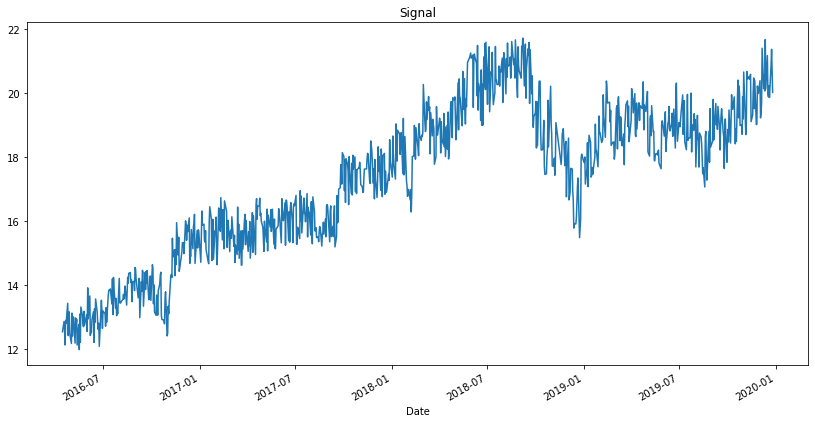

In [6]:
df['Signal'].plot(figsize = (14,7),title = 'Signal')

Plot of the Signal: The signal seems very volatile

Assumption: Assuming that the signal is n day lagged forecast, the analysis is carried out. 
It was found that, after plotting a visual plot of the signal, there is lot of noise in it. So, the noise is smoothed out by taking a n-day moving average. The n value and the lag value is decided on the validation set.
Since the Signal series' scale is different from that of the price series, next step is to establish a relationship between the signal and the prices. Since it is also not known beforehand as to which price the signal is predicting, the analysis is done on all the prices separately.

Data is divided into three parts, (First 1/3 is train data, next 1/3 - 2/3 is the validation data, and the rest is test data)
Training data is used to estabish the relationship by running a OLS regression. The OLS regression gives out the possible linear relationship. A big assumption here is that the relationship between Signal and Prices is linear and that it remains constant for us to use the coefficients in the further period. The hyperparameters, lag and n-day moving average value is decided on the validation set based on the accuracy. Then train data and validation data are then merged to form a new training set, and the final results are shown on the test set. 

We finally see if the price forecast is accurately predicting the prices

In [7]:
result_df = pd.DataFrame(columns = ['X','RSquared','Const','XCoeff','Lag','n_day_MA','accuracy'])
count = 0
for lag in [1,2,3,5]: 
    for n_day_MA in [3,5]:
        for price in ['Adj Close','Close','High','Low','Open']:
            dataset = df.copy()
            dataset['Signal'] = dataset['Signal'].shift(lag) #n_day lags
            dataset['Signal'] = dataset['Signal'].rolling(n_day_MA).mean() #n day moving average of the signal series to smoothen it out
            dataset.dropna(inplace = True)
            train_df = dataset[:int(len(df)/3)]
            valid_df = dataset[int(len(df)/3):2*int(len(df)/3)]
            test_df = dataset[2*int(len(df)/3):]
            y = np.array(train_df['Adj Close'])
            X = np.array(train_df['Signal'])
            X = sm.add_constant(X)
            model = sm.OLS(y, X)
            results = model.fit()
            r_squared = results.rsquared
            const = results.params[0]
            x_coeff = results.params[1]
            valid_df['CorrectedSignal'] = valid_df['Signal']*x_coeff + const 
            accuracy = explained_variance_score(valid_df['Adj Close'],valid_df['CorrectedSignal'])
            result_df.loc[count] = [price,r_squared,const,x_coeff,lag,n_day_MA,accuracy]
            count+=1
result_df

,X,RSquared,Const,XCoeff,Lag,n_day_MA,accuracy
0,Adj Close,0.952118,6.039099,7.921514,1,3,0.781498
1,Close,0.952118,6.039099,7.921514,1,3,0.781498
2,High,0.952118,6.039099,7.921514,1,3,0.781498
3,Low,0.952118,6.039099,7.921514,1,3,0.781498
4,Open,0.952118,6.039099,7.921514,1,3,0.781498
5,Adj Close,0.970226,3.653411,8.091192,1,5,0.793593
6,Close,0.970226,3.653411,8.091192,1,5,0.793593
7,High,0.970226,3.653411,8.091192,1,5,0.793593
8,Low,0.970226,3.653411,8.091192,1,5,0.793593
9,Open,0.970226,3.653411,8.091192,1,5,0.793593


The above table shows the accuracy on the validation set for different hyperparameters. The one with highest accuracy on the validation set is selected and thus the hyperparameters (Price series, Lag, n-day-moving average paramter) are decided. Use of nested for-loops was necessary because the hyperparameters are external to the model used in estimating the relationship between the price series and the signal

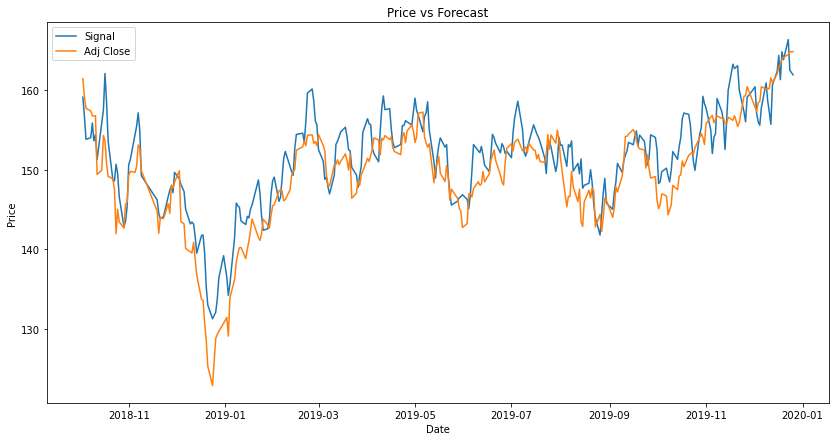

In [8]:
new_df = df.copy()
#n_day lags
new_df['Signal'] = new_df['Signal'].shift(result_df.loc[result_df['accuracy'].idxmax()]['Lag']) 
#n day moving average of the signal series to smoothen it out
new_df['Signal'] = new_df['Signal'].rolling(result_df.loc[result_df['accuracy'].idxmax()]['n_day_MA']).mean() 
new_df.dropna(inplace = True)
new_train = new_df[:2*int(len(df)/3)]
test_df = new_df[2*int(len(df)/3):]
y = np.array(new_train['Adj Close'])
X = np.array(new_train['Signal'])
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
r_squared = results.rsquared
const = results.params[0]
x_coeff = results.params[1]
test_df['CorrectedSignal'] = test_df['Signal']*x_coeff + const 
accuracy = explained_variance_score(test_df['Adj Close'],test_df['CorrectedSignal'])
plt.figure(figsize=(14,7))
plt.plot(test_df['CorrectedSignal'])
plt.plot(test_df[result_df.loc[result_df['accuracy'].idxmax()]['X']])
plt.title('Price vs Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(['Signal',result_df.loc[result_df['accuracy'].idxmax()]['X']],loc='upper left')
plt.show()

Visually, the estimated 'Price Forecast' seems to be tracking the price series (Adj Close) in this case very well. As it is able to capture the variance by almost 82% on the test set, there is a possibility that the signal could be an engineered variable from the lagged price series. So, analysis must be done with caution

<AxesSubplot:>

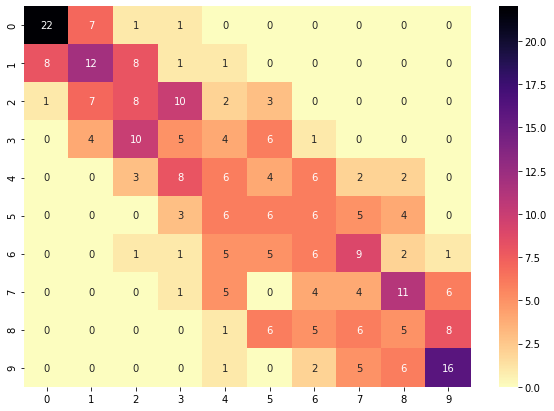

In [9]:
disc_test_df = pd.DataFrame(columns = test_df.columns)
for col in test_df.columns:
    disc_test_df[col] = pd.qcut(test_df[col],10,labels = False)
df_cm = confusion_matrix(disc_test_df['Adj Close'],disc_test_df['CorrectedSignal'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap = 'magma_r')

Looking at the confusion matrix heatmap by dividing the continuous data into deciles and seeing if most values are falling along the diagonal or not helps with the accuracy measure. The above confusion matrix gives us a clue to the accuracy and here most values are along the diagonal. We can further look at other accuracy measures

In [10]:
print('Explained Variance Score is :',explained_variance_score(test_df['Adj Close'],test_df['CorrectedSignal']))
print('MAPE is ',mean_absolute_percentage_error(test_df['Adj Close'],test_df['CorrectedSignal']))

Explained Variance Score is : 0.8221786390596838
MAPE is  1.9218896889387045


The Explained Variance score is very high on the test set at 82%, and MAPE is around 2% indicating that the 'Price Forecast' is is a good forecast of the price series. But we also have to wary of a few points. To give an overview of the entire problem, 

Any forecasting model's accuracy is determined by how the model is performing out-of-sample.The model with low Bias and low Variance is considered to be the best model. But the prices of financial instruments have so much noise contained in them, and is usually difficult to model the series using prices. They are hence converted to returns(1-day, 1-week, 1-month,  and so on). It also helps with the assumption that returns follow normal distribution and standard time-series modelling techniques can be applied to them, giving us better forecasts of expected returns and expected standard deviation to fit into the framework of Arbitrage Pricing Theory and CAPM. Moreover, as the returns follow normal distributions, the prices follow log-normal distribution. Thus prices can be forecasted using returns.

Coming to the efficacy of the product, the measures R_squared and correlation are useful in determining the model fit, but these are not helpful is determining the actual accuracy of the forecasts. THe forecast accuracy should be determined by the measures such as Mean Absolute Percentage Error, Root Mean Squared Error, Explained Variance score. The problem here is with the lack of information that we do not know if the signal is for the today's price forecast or the next day's forecast or the next week's. The correlation and R_squared are similar for both lagged Signal and non-lagged Signal. That itself makes these measures unreliable. Thus, the relationship between Signal and the Price Forecast can be really helpful. From the data provided, it can be estimated by dividing the data and estimating the coefficients on one part of the data and used to test accuracy on the later part of the data, avoiding biases and overfitting.

To look at the efficacy of the signal, the accuracy measures Explained Variance, RMSE, MAPE, the confusion matrix output indicate us that the signal is very good in predicting the prices. But, the 'Price Forecast' calculated here in the above analysis also lags the signal and calculates the 5-day moving average as well. These techniques should not be used when the signal has a straight-forward relationship with one of the price series. So, the modified signal and the estimated 'Price Forecast'are good forecasts. And since the best price measure for the forecast signal is 'Adjusted Close', if there is a stock-split/reverse stock split, it is bound to change. That also needs to be considered while taking a decision. 

Recommendations:

1) Further testing the forecast accuracy on the future dataset, by obtaining the signal continuously in advance. Out-of-sample testing, to verify that the given signal is not manipulated by any sort of shifting the price series and adding noise to it. This is an internal check and gives us an insight into the product's believability.

2) Generally, returns forecast is easier to model, and obtaining the returns forecast is helpful in fitting the APT model used for portfolio management decision making along with the covariance matrix estimation. Returns can easily be obtained from price series, but the reverse (Obtaining prices from return forecast) is usually performed. Factor models are important in identifying risk premia factors and the sources of risk. The alpha factor models, if successful can give us with information helping the portfolio manager in taking decisions in the asset allocation